We trying

Research Diary: https://drive.google.com/open?id=1zBXLaCameGhHj8RbXeGkep6_gZnUAiAnhGrVE1aEr-4

In [35]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
from scipy import signal
from copy import deepcopy
import math

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
import sklearn.metrics

In [7]:
# Force divider function
def force_divider(x):
    k_outer = 3.738
    k_inner = 0.368
    dist = x/k_inner
    return (k_outer + k_inner)*dist

# FSR model function
def FSR_model(x):
    return 131.2*np.exp(0.7801*x)/1000

# Slope function
def slope(dataVector):
    dydx = []
    for i in range(1, len(dataVector)):
        diff = dataVector[i] - dataVector[i-1]
        dydx.append(diff)
    finalDiff = dataVector[i] - dataVector[i-1] # Added just to make the final array the proper dimensions 
    dydx.append(finalDiff)
    return np.array(dydx)

# Mean function
def mean(dataVec):
    return sum(dataVec) / len(dataVec)

# Standard Deviation
def sd(dataVec):
    avg = mean(dataVec)
    tot = 0
    for elem in dataVec:
        tot = tot + (elem - avg)*(elem - avg)
    return math.sqrt(tot / len(dataVec))

def impulse(data_matrix):
    #total impulse function for a single matrix of data 
    #iterates over data and computes the total impulse for all sensors over time 
    fsr_data = data_matrix[:,0:12]
    impulse = 0
    for col in np.arange(0,12):
        single_FSR = data_matrix[:,col]
        time = data_matrix[:,0]
        for i in np.arange(0,len(time)-1):
            delta_t = time[i+1]- time[i]
            averagef = (single_FSR[i+1] + single_FSR[i])/2 
            impulse = impulse + averagef*delta_t
    return impulse 

def jerk(data_matrix): 
    #iterates over data and computes the max jerk for each sensor over time
    #takes the max jerk over all FSR sensors and returns  
    fsr_data = data_matrix[:,0:12]
    jerk_array = []
    for col in np.arange(0,12):
        single_FSR = data_matrix[:,col]
        time = data_matrix[:,0]
        all_jerks = []
        for i in np.arange(0,len(time)-1):
            delta_t = time[i+1] - time[i]
            delta_f = single_FSR[i+1] - single_FSR[i]
            all_jerks.append(delta_f/delta_t)
        jerk_array.append(np.amax(all_jerks))
    max_jerk = np.amax(jerk_array)
    return max_jerk

def max_force(data_matrix):
    #max force readings across all sensors for a single matrix of data 
    fsr_data = data_matrix[:,0:12]
    force_array = [] 
    for col in np.arange(0,12):
        single_FSR = data_matrix[:,col]
        max_force_sensor = np.amax(single_FSR)
        force_array.append(max_force_sensor)
    max_force = np.amax(force_array)
    return max_force

In [8]:
# test = np.array([1, 2, 3, 4, 5])
# print(mean(test))
# print(sd(test))

In [9]:
# Labels
    # Drop = 1
    # Nothing = 2
    # Squeeze = 3
    
# Add Fall data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/drop"
fsrData = []
accelData = []
totData = []
for num in np.arange(1, 21):
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrDrop = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelDrop = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totDrop = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrDrop = fsrDrop.to_numpy()
    accelDrop = accelDrop.to_numpy()
    totDrop = totDrop.to_numpy()
    fsrData.append(fsrDrop)
    accelData.append(accelDrop)
    totData.append(totDrop)
 
# Add Nothing data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/nothing"
for num in np.arange(1, 11):
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelNoth = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrNoth = fsrNoth.to_numpy()
    accelNoth = accelNoth.to_numpy()
    totNoth = totNoth.to_numpy()
    fsrData.append(fsrNoth)
    accelData.append(accelNoth)
    totData.append(totNoth)
    
# Add Squeeze data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/squeeze"
for num in np.arange(1, 35):
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelSqueeze = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrSqueeze = fsrSqueeze.to_numpy()
    accelSqueeze = accelSqueeze.to_numpy()
    totSqueeze = totSqueeze.to_numpy()
    fsrData.append(fsrSqueeze)
    accelData.append(accelSqueeze)
    totData.append(totSqueeze)

# print(np.shape(fsrData))
# print(np.shape(accelData))
# print(np.shape(totData))


In [10]:
placeHold = []
for m in fsrData:
    m = force_divider(FSR_model(m *5/1023))  
    placeHold.append(m)

for k in totData:
    k[:, 0:12] = force_divider(FSR_model(k[:, 0:12] *5/1023))

fsrData = placeHold

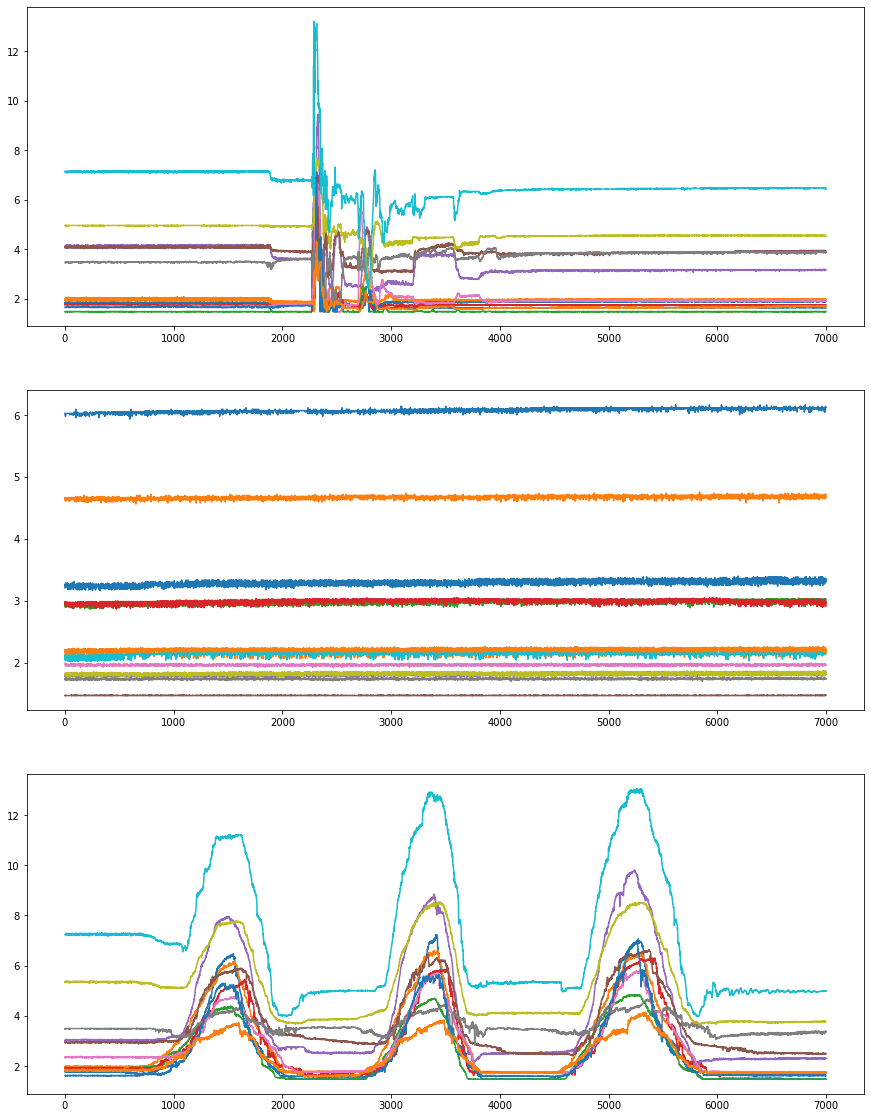

In [11]:
# Plot FSR data (Taking first tests as example)
plt.figure(figsize=(15, 20))
plt.subplot(311)
plt.plot(fsrData[0])
plt.subplot(312)
plt.plot(fsrData[20])
plt.subplot(313)
plt.plot(fsrData[30])

In [12]:
# Trim FSR data-- 1000-6000 ms
fsrTrunc = []
for i in range(0, len(fsrData)):
    testTrunc = fsrData[i][:, :]
    fsrTrunc.append(testTrunc)
    
# print(np.shape(fsrData))

# plt.figure(figsize=(15, 20))
# plt.subplot(211)
# plt.plot(fsrData[30])
# plt.subplot(212)
# plt.plot(fsrTrunc[30])

In [13]:
# # Plot Accel data
# plt.figure(figsize=(15, 20))
# plt.subplot(311)
# plt.plot(accelData[0])
# plt.subplot(312)
# plt.plot(accelData[20])
# plt.subplot(313)
# plt.plot(accelData[30])

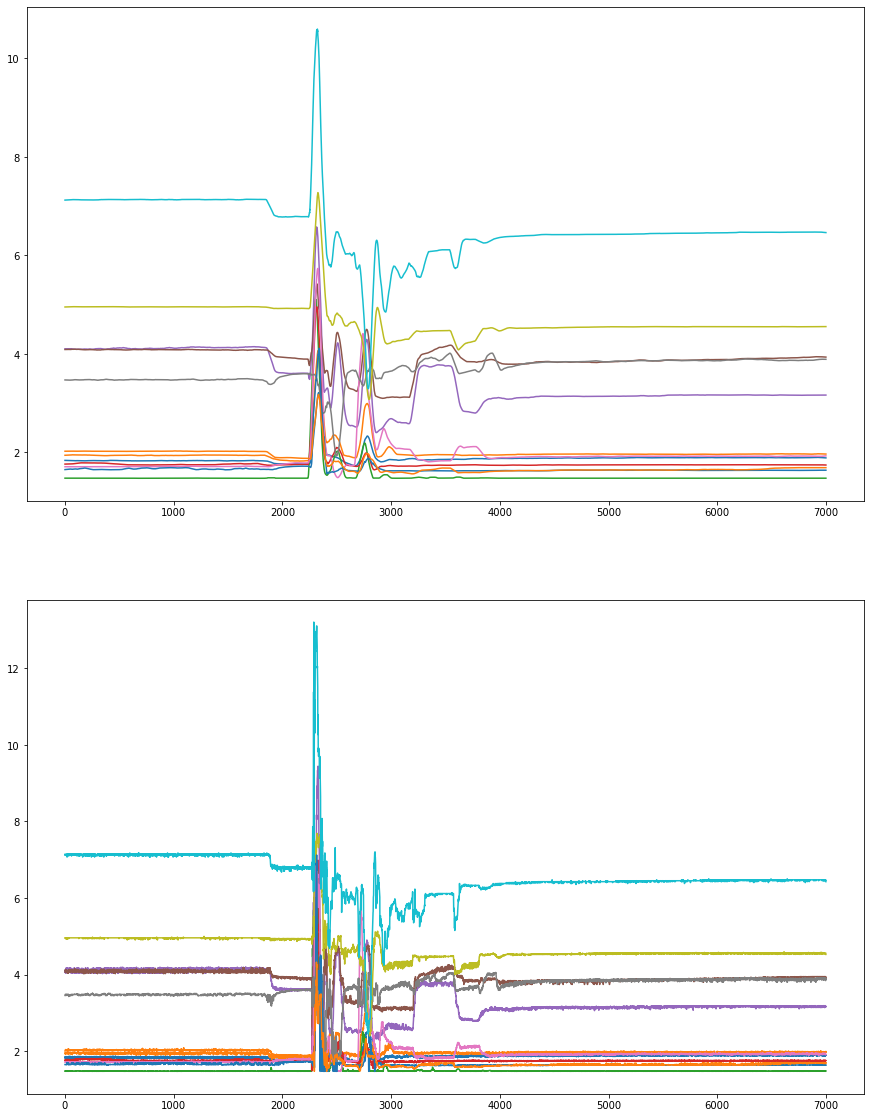

In [14]:
# Try smoothing out fsr data

fsrRefined = deepcopy(fsrTrunc)

for test in fsrTrunc:
    for k in range(0, 12):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 1)       

plt.figure(figsize=(15, 20))
plt.subplot(211)
plt.plot(fsrData[0])
plt.subplot(212)
plt.plot(fsrRefined[0])

In [15]:
# Compress function
def compress(data):
    sliceLen = 30
    i = len(data) // sliceLen
    comp = []
    for k in range(0, i):
        vals = data[k*sliceLen:(k+1)*sliceLen]
        avg = mean(vals)
        comp.append(avg)
    return comp

In [16]:
fsrComp = []
for test in fsrRefined:
    compArray = []
    for k in range(0, 12):
        com = compress(test[:, k])
        compArray.append(com)
    compArray = np.array(compArray)
    fsrComp.append(compArray.T)

# plt.figure(figsize=(15, 20))
# plt.subplot(211)
# plt.plot(fsrRefined[20])
# plt.subplot(212)
# plt.plot(fsrComp[20])

In [17]:
feature_data = []
for m in fsrComp:
    maxf = max_force(m)
    i = impulse(m)
    features = [maxf, i]
    feature_data.append(features)


In [18]:
# Slope vectors for FSR data
fsrSlopes = []
for i in range(0, 64):
    fsrVec = slope(fsrComp[i])
    fsrSlopes.append(fsrVec)

# FSR data + fsr slopes
fsrAndSlope = []
for i in range(0, 64):
    combinedData = np.append(fsrComp[i], fsrSlopes[i], axis = 1)
    fsrAndSlope.append(combinedData)

In [19]:
# Standardize mean and standard deviation

# print("Original Means:")
# for col in range(0, 12):
#     print(mean(fsrComp[0][:, col]))
# print("\n")
# print("Original SDs:")
# for col in range(0, 12):
#     print(sd(fsrComp[0][:, col]))


# for test in fsrComp:
#     for k in range(0, 12):
#         test[:, k] = test[:, k] - mean(test[:, k])
#         test[:, k] = test[:, k] / sd(test[:, k])

# print("New Means:")
# for col in range(0, 12):
#     print(mean(fsrComp[0][:, col]))
# print("\n")
# print("New SDs:")
# for col in range(0, 12):
#     print(sd(fsrComp[0][:, col]))

# plt.figure(figsize=(15, 20))
# plt.subplot(311)
# plt.plot(fsrComp[0])
# plt.subplot(312)
# plt.plot(fsrComp[20])
# plt.subplot(313)
# plt.plot(fsrComp[30])

(64, 233, 1)


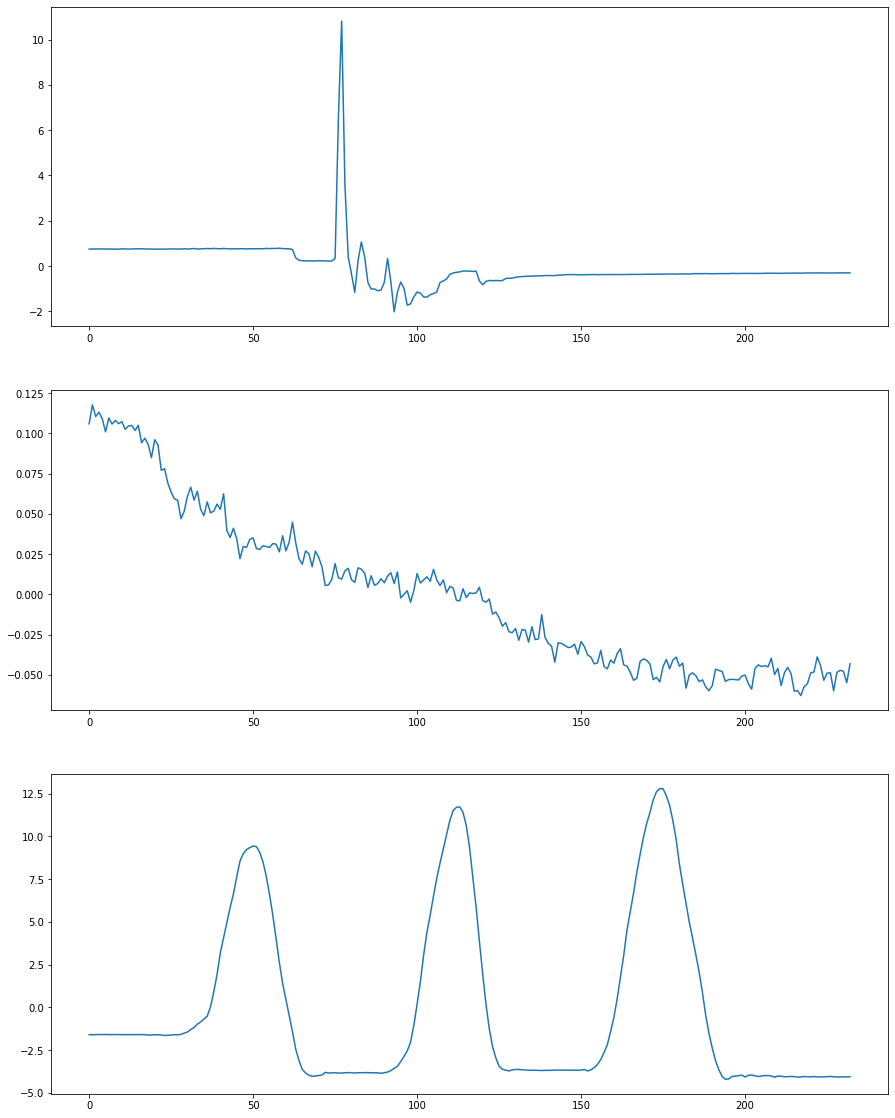

In [20]:
# PCA
pcaFSR = deepcopy(fsrComp)
pca = PCA(n_components =1)

for i in range(0, len(pcaFSR)):
    pcaFSR[i] = pca.fit_transform(pcaFSR[i])


print(np.shape(pcaFSR))
plt.figure(figsize=(15, 20))
plt.subplot(311)
plt.plot(pcaFSR[0])
plt.subplot(312)
plt.plot(pcaFSR[20])
plt.subplot(313)
plt.plot(pcaFSR[30])



In [21]:
# Labels!

l1 = np.ones((20,), dtype=int) 
l2 = 2*np.ones((10,), dtype=int) 
l3 = 3*np.ones((34,), dtype=int)
labels = np.concatenate((l1, l2, l3), axis=0)

# print(np.shape(labels))

In [22]:
# Prepare data for algorithms
nsamples, nx, ny = np.shape(pcaFSR)
reformated_data = np.reshape(pcaFSR,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, labels, random_state=0)

# K-Fold Cross Validation
x = reformated_data
y = labels
skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(x, y)

4

In [23]:
# Gaussian Naive-Bayes

for train_index, test_index in skf.split(x, y):
    X_train, X_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
    nb = GaussianNB().fit(X_train, y_train)
    print("\n")
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    print("Predicted labels = " + str(y_pred))
    print("Correct labels =   " + str(y_test))



1.0
Predicted labels = [1 1 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3]
Correct labels =   [1 1 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3]


0.9411764705882353
Predicted labels = [1 1 1 3 1 2 2 2 3 3 3 3 3 3 3 3 3]
Correct labels =   [1 1 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3]


1.0
Predicted labels = [1 1 1 1 1 2 2 3 3 3 3 3 3 3 3]
Correct labels =   [1 1 1 1 1 2 2 3 3 3 3 3 3 3 3]


0.7333333333333333
Predicted labels = [3 3 3 1 1 1 2 3 3 3 3 3 3 3 3]
Correct labels =   [1 1 1 1 1 2 2 3 3 3 3 3 3 3 3]


In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)


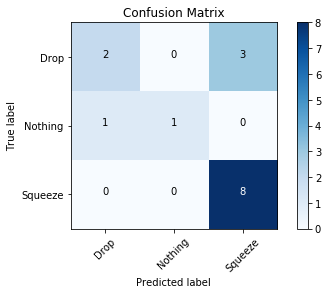

In [41]:
# Confusion Matrix

class_names = ['Drop', 'Nothing', 'Squeeze']
pcaFSR_cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(pcaFSR_cnf_matrix, classes=class_names, title='Confusion Matrix')